<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# Caderno de **Exercícios**
**Profissão: Analista de Dados v2 Módulo 16** | Análise de Dados: Análise Exploratória de Dados de Logística II<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
Aluno [Rafael Barbosa](https://www.linkedin.com/in/barbosa89/)

---

## Análise Exploratória de Dados de Logística

O storytelling apesenta resultados orientados para os dados e pipelines.

Este notebook serve como um guia para construção de análise exploratória de dados e foi inspirado nos materiais de aula da [EBAC](https://ebaconline.com.br/) e neste [modelo de notebook](https://www.kaggle.com/code/rafieb/introduction-to-regular-expressions/edit). Fique à vontade para copiar os códigos e busque explorar os dados ao máximo. Por fim, compare e publique seu notebook no [Kaggle](https://www.kaggle.com/). Enjoy!

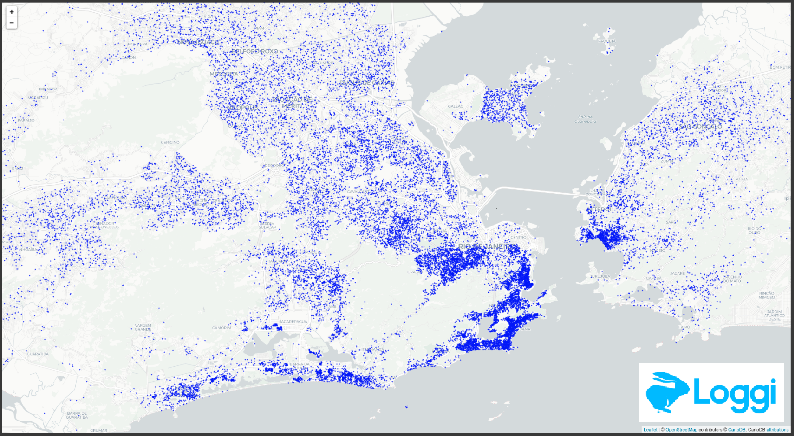

# Conteúdo do caderno <a id='top'></a>

1. [Relevância do problema](#problema)
2. [Importação de bibliotecas](#bibliotecas)
3. [Configuração do dataframe](#dataframe)
4. [Análise exploratória](#explora)
5. [Limpeza e transformação](#transforma)
6. [Perspectivas de negócios](#negocios)
7. [Resumo e insights](#insights)


## 1. Relevância do problema <a id='problema'> [↑](#top)

#### [Loggi](https://www.loggi.com/)
Focada em logística e tecnologia, a Loggi é uma unicórnio do Brasil e está avaliada em US$ 1 bilhão ([fonte](https://carreira.loggi.com/conheca-a-loggi/nosso-negocio/)). Entregava documentos entre 2013 e 2014, entrando no segmento de e-commerce dois anos depois e desde 2017 tem atuado nas entregas de alimentos.

#### Loggi BUD
 O Loggi Benchmark for Urban Deliveries é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que representam os desafios enfrentados por essa startup em sua escala: otimização das rotas de entregas, alocação nos veículos de entrega, capacidade da frota de veículos, dinâmica de distribuição nos hubs regionais em cada cidade, etc.




## 2. Importação de bibliotecas <a id='bibliotecas'> [↑](#top)

In [ ]:
# importação de bibliotecas

import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip3 install geopandas;
import geopandas

import geopy
#from geopy import geocoders
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3. Configuração do dataframe <a id='dataframe'> [↑](#top)

Vamos trabalhar com um sub conjunto dos dados originais ([link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md)) e instâncias de treino de `cvrp` da cidade de Brasília estão consolidadas em um único arquivo `JSON`. O dado bruto é um arquivo do tipo `JSON` com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional, como no exemplo a seguir:

``` json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


 Legenda
 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.


 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

In [ ]:
# - coleta de dados;
# baixa os dados brutos e carrega em um dataframe pandas
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

In [ ]:
# - wrangling da estrutura;

# descompacta a coluna 'origin' nas colunas "hub_lng" e "hub_lat"
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# descompacta a coluna 'deliveries' nas colunas "delivery_size", "delivery_lng" e "delivery_lat", desconsiderando "id"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_df = deliveries_df.drop("deliveries", axis=1) # exclui a coluna 'deliveries' do dataframe original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True) # mescla o as novas colunas ao novo dataframe original
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

## 4. Análise exploratória <a id='explora'> [↑](#top)


In [ ]:
deliveries_df.shape # número de linhas e colunas

In [ ]:
deliveries_df.dtypes # colunas e seus respectivos tipos de dados.

In [ ]:
# Atributos categóricos
deliveries_df.select_dtypes("object").describe().transpose()

In [ ]:
#Atributos numéricos
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

In [ ]:
deliveries_df.isna().any() # Dados faltantes

In [ ]:
deliveries_df.info() # Informações do dataframe pandas

## 5. Limpeza e transformação <a id='transforma'> [↑](#top)


In [ ]:
# código de manipulação de dados:
# - enriquecimento;

# geocodificação

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent= 'm16 ebac geocode')
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")
print(json.dumps(location.raw, indent=2, ensure_ascii=False))

# aplica a geocodificação nas coordenadas das três regiões e extrair informações de cidade e bairro.
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

# combinando ao DataFrame principal
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]


In [ ]:
# Geocodificação reversa da entrega usando um repositório pessoal
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")


In [ ]:
# atuaiza o dataframe principal
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

In [ ]:
# Qualidade do dados está relacionado a consistência do seu `schema`, valores faltantes, etc.
# - controle de qualidade;
deliveries_df.info()
print('-------------------------')
deliveries_df.isna().any()


In [ ]:
# % dados nulos em "cidade"
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

In [ ]:
# % dados nulos em "bairros"
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

In [ ]:
# objetos mais comuns em "cidade"
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

In [ ]:
# objetos mais comuns em "bairros"
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

## 6. Perspectivas de negócios <a id='negocios'> [↑](#top)

Visualização das coordenadas dos hubs e das entregas no mapa do Distrito Federal, segmentados pela região dos hubs.

In [ ]:
# Download dos dados do mapa do Distrito Federal do site oficial do IBGE para criar o DataFrame mapa.
# note a coluna geometry.
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
print(deliveries_df.columns)

In [ ]:
# Código de visualização de dados no mapa

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])


In [ ]:
# Código de visualização de dados em barras

data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={data.columns[2]: 'region_percent'}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');


In [ ]:
data

## 7. Resumo e insights <a id='insights'> [↑](#top)


As entregas estão corretamente alocadas aos seus respectivos hubs;
Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego.